In [1]:
import matplotlib.pyplot as plt
import flowkit as fk
import os
import pandas as pd
import FlowCal
import flowsom as fs
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn_extra.cluster import CLARA
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import networkx as nx
import re
from flowio import create_fcs
from scipy.stats import gmean
from fcsy import DataFrame
from fcsy import write_fcs
import matplotlib.colors as mcolors
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score, adjusted_rand_score


In [2]:
# Definir los directorios de entrada y salida
work_dir = r"C:/Users/Usuario/OneDrive/Escritorio/Palex/Muestras TFM/SAMPLES_SCAFOLD"
input_dir = work_dir + '/Muestras_cluster'
output_dir = work_dir + '/clusters_clara'
flowsom_dir = work_dir + '/clusters_flowsom'
phenograph_dir = work_dir + '/clusters_phenograph'
clara_dir = work_dir + '/clusters_clara'

In [3]:
# Función para limpiar nombres de variables
def limpiar_nombre_variable(nombre):
    # Reemplazar caracteres no deseados con un guion bajo o eliminarlos (en este caso se eliminan)
    nombre_limpio = re.sub(r'[^\w]', '_', nombre)
    return nombre_limpio

Cogemos las muestras y controles normalizados con CyCombine

In [4]:
# Cogemos los labels antes de normalizar para añadirlos al final
gated_dir = work_dir + '/Controles_muestras_gated'
archivos_fcs = [f for f in os.listdir(gated_dir) if f.endswith('.fcs')]

# Lista para almacenar las columnas OmiqFilter
omiq_filter_list = []

# Procesar cada archivo FCS
for archivo in archivos_fcs:
    archivo_fcs = os.path.join(gated_dir, archivo)
    
    # Leer el archivo FCS
    fcs_data = FlowCal.io.FCSData(archivo_fcs)
    
    # Convertir el objeto FCSData a un DataFrame de pandas
    df = pd.DataFrame(fcs_data, columns=fcs_data.channels)
    
    # Almacenar la columna OmiqFilter en la lista
    omiq_filter_list.extend(df['OmiqFilter'].tolist())


Guardamos en un df solo el gating de los controles para hacer los nodos landmark y en otro guardamos todo (controles y muestras)

In [5]:
Norm_dir = work_dir + '/Controles_muestras_normalizados'
archivo_controles = 'Controles_muestras_normalizados.csv'
archivo = os.path.join(Norm_dir, archivo_controles)

df_gating_muestras_controles = pd.read_csv(archivo)

# Añadir la columna OmiqFilter a los datos de gating
df_gating_muestras_controles['OmiqFilter'] = omiq_filter_list

In [6]:
# Cambiamos los valores de la columna OmiqFilter por los nombres reales
omiq_filter_dict = {
    0: "NA",
    1: "CM CD8",
    2: "Monocitos intermedios",
    3: "Treg",
    4: "TEMRA CD8",
    5: "Monocitos clasicos",
    6: "Monocitos no clasicos",
    7: "Non Treg",
    8: "Linfocitos B",
    9: "NK",
    10: "EM CD8",
    11: "Granulocitos",
    12: "Naive CD8"
}

df_gating_muestras_controles['OmiqFilter'] = df_gating_muestras_controles['OmiqFilter'].replace(omiq_filter_dict)

In [7]:
# Asegurarse de que la columna 'sample' es de tipo cadena (string)
df_gating_muestras_controles['sample'] = df_gating_muestras_controles['sample'].astype(str)

# Filtrar las filas donde 'sample' empieza con 'C' y no es nulo
df_gating = df_gating_muestras_controles[
    df_gating_muestras_controles['sample'].str.startswith('C')
]

In [8]:
df_gating = df_gating.drop(columns=['sample', 'batch','condition','id','label'])
# Eliminamos las filas que tienen NA en la columna OmiqFilter (no queremos un nodo NA)
df_gating = df_gating[df_gating['OmiqFilter'] != 'NA']

# No dropeamos sample porque lo usamos despues para comparar distribuciones con los clusters
df_gating_muestras_controles = df_gating_muestras_controles.drop(columns=['batch','condition','id','label'])

Calculamos el MFI de cada marcador (media o mediana) para calcular la similitud de cada par de nodos

In [9]:
# Primero vamos a coger las poblaciones obtenidas por gating
medianas = pd.DataFrame()
medias = pd.DataFrame()

# Agrupar por 'OmiqFilter' y calcular medianas, medias y medias geométricas
grouped = df_gating.groupby('OmiqFilter')

for poblacion, group in grouped:
    # Obtener el nombre de la población desde la columna 'OmiqFilter'
    variable_name = limpiar_nombre_variable(poblacion)
    
    # Excluir la columna 'OmiqFilter'
    df_gating_numeric = group.drop(columns=['OmiqFilter'])
    
    # Guardar el DataFrame en una variable global
    globals()[variable_name] = df_gating_numeric
    
    # Calcular medianas, medias y medias geométricas
    medianas[variable_name] = df_gating_numeric.median()
    medias[variable_name] = df_gating_numeric.mean()

# Transponer los DataFrames de medianas, medias y medias geométricas
medias_gating = medias.T
medianas_gating = medianas.T

In [10]:
cosine_similarities = cosine_similarity(medianas_gating)
cosine_similarities = pd.DataFrame(cosine_similarities, index=medianas_gating.index, columns=medianas_gating.index)

## Grafos (todos los archivos en uno) con Jerarquía (opcional)

In [11]:
# Definir la jerarquía de nodos (si no queremos jerarquia, dejar el diccionario vacio)
jerarquia = {
    'Linfocitos': ['Linfocitos_B', 'Treg', 'Non_Treg', 'Naive_CD8', 'EM_CD8', 'CM_CD8', 'TEMRA_CD8', 'NK'],
    'Monocitos': ['Monocitos_no_clasicos', 'Monocitos_intermedios', 'Monocitos_clasicos']
}

In [12]:
# Definir el directorio donde estan los clusters
dir_clusters = flowsom_dir

In [13]:
# Extraemos del directorio todos los csv menos 'control_clusters.csv'
archivos = [f for f in os.listdir(dir_clusters) if f.endswith('.csv') and not f.startswith('C')]
archivos_control = [f for f in os.listdir(dir_clusters) if f.endswith('.csv') and f.startswith('C')]

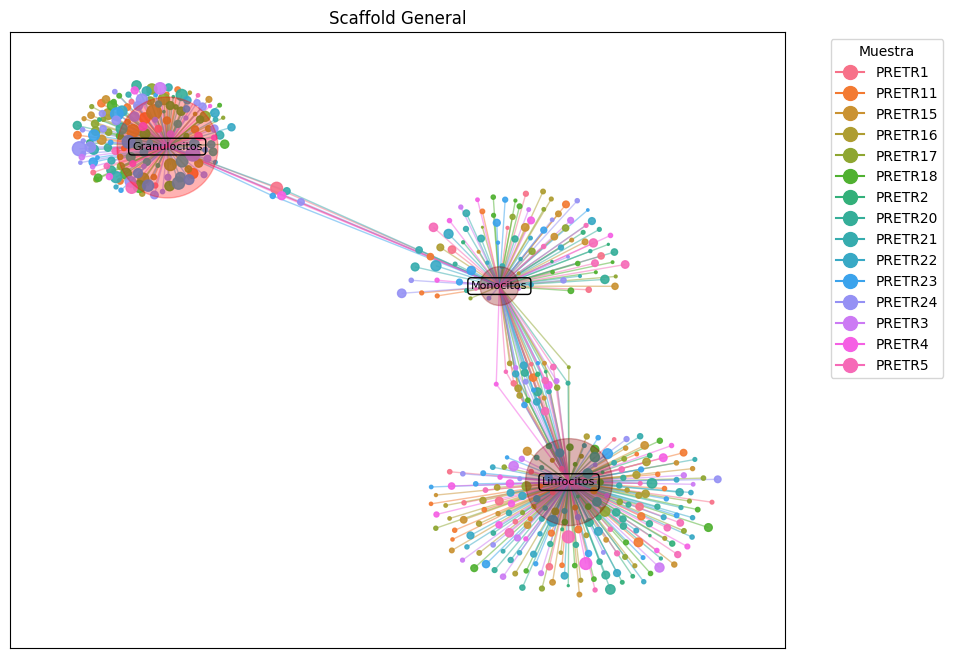

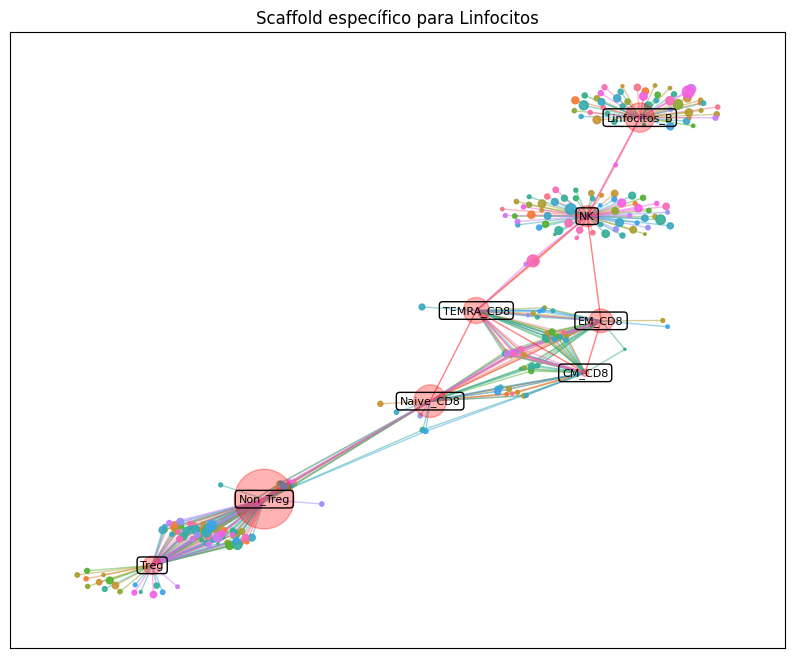

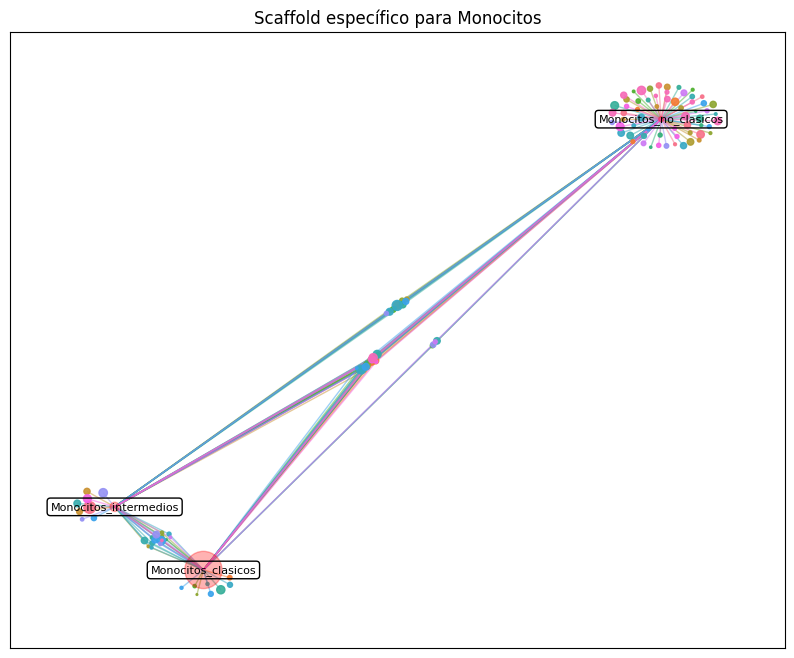

In [15]:
# Crear el grafo principal
G = nx.Graph()

# Crear una lista de nombres de nodos
nodos_gating = medias_gating.index.tolist()

# Añadir nodos de jerarquía (solo nodos padre)
for grupo in jerarquia.keys():
    num_eventos = sum(len(globals()[limpiar_nombre_variable(hijo)]) for hijo in jerarquia[grupo] if limpiar_nombre_variable(hijo) in globals())
    size = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
    G.add_node(grupo, color='darkred', size=size)

# Crear el SCAFFOLD con los nodos de gating
for nodo in nodos_gating:
    if nodo not in jerarquia:
        num_eventos = len(globals()[limpiar_nombre_variable(nodo)])  # Calcula el número de eventos para los nodos de gating
        size = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
        G.add_node(nodo, color='red', size=size)

# Crear una matriz de similitud del coseno usando medianas_gating
valores_medios_gating = np.vstack([medias_gating.loc[nodo].values for nodo in medias_gating.index])
matriz_similitud_coseno_gating = cosine_similarity(valores_medios_gating)
np.fill_diagonal(matriz_similitud_coseno_gating, 0)
umbrales_gating = np.percentile(matriz_similitud_coseno_gating, 65, axis=0)

# Añadir aristas solo entre nodos similares basados en el umbral de similitud del coseno
for i in range(len(nodos_gating)):
    for j in range(i + 1, len(nodos_gating)):
        if matriz_similitud_coseno_gating[i, j] >= umbrales_gating[j]:
            G.add_edge(nodos_gating[i], nodos_gating[j], weight=matriz_similitud_coseno_gating[i, j]**4, color='red')

# Calcular las posiciones de los nodos de gating
pos_gating = nx.spring_layout(G, weight='weight', seed=2)

# Agrupar nodos hijos bajo nodos padres
for grupo, subnodos in jerarquia.items():
    for subnodo in subnodos:
        if subnodo in G:
            for vecino in list(G.neighbors(subnodo)):
                if vecino not in subnodos:
                    G.add_edge(grupo, vecino, weight=G[subnodo][vecino]['weight'], color='red')

# Calcular las posiciones generales
pos_gating_general = nx.spring_layout(G, pos=pos_gating, fixed=nodos_gating, weight='weight', seed=1)

# Crear grafos específicos para cada nodo padre
grafos_especificos = {}
for nodo_padre in jerarquia.keys():
    G_especifico = nx.Graph()
    nodos_hijos = jerarquia[nodo_padre]

    # Añadir nodos de gating hijos al grafo específico
    for nodo_hijo in nodos_hijos:
        num_eventos = len(globals()[limpiar_nombre_variable(nodo_hijo)])
        size = num_eventos * 0.01
        G_especifico.add_node(nodo_hijo, color='red', size=size)

    # Filtrar la matriz de similitud del coseno para los nodos hijos
    indices_hijos = [nodos_gating.index(nodo_hijo) for nodo_hijo in nodos_hijos if nodo_hijo in nodos_gating]
    submatriz_similitud_hijos = matriz_similitud_coseno_gating[np.ix_(indices_hijos, indices_hijos)]

    # Calcular los umbrales de similitud para los nodos de gating hijos
    np.fill_diagonal(submatriz_similitud_hijos, 0)
    umbrales_hijos = np.percentile(submatriz_similitud_hijos, 70, axis=0)

    # Añadir aristas solo entre nodos similares
    for i in range(len(nodos_hijos)):
        for j in range(i + 1, len(nodos_hijos)):
            if submatriz_similitud_hijos[i, j] >= umbrales_hijos[j]:
                G_especifico.add_edge(nodos_hijos[i], nodos_hijos[j], weight=submatriz_similitud_hijos[i, j]**4, color='red')

    # Calcular posiciones
    pos_hijos = nx.spring_layout(G_especifico, weight='weight', seed=1)

    # Guardar el grafo específico
    grafos_especificos[nodo_padre] = (G_especifico, pos_hijos)


num_archivos = len(archivos)
colores = sns.color_palette('husl', num_archivos)

porcentajes_clusters = {}
nodos_cluster_todos = []

clusters_unidos_a_gating = {nodo_gating: [] for nodo_gating in nodos_gating + list(jerarquia.keys())}

leyenda = {}
tamanos_nodos = {}

for idx, archivo in enumerate(archivos):
    archivo_path = os.path.join(dir_clusters, archivo)
    df_cluster = pd.read_csv(archivo_path)

    # Eliminar columnas no necesarias
    columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
    df_cluster = df_cluster.drop(columns=[col for col in columnas_a_eliminar if col in df_cluster.columns])

    medias_cluster = df_cluster.groupby('cluster').mean()
    medias_cluster = medias_cluster.rename(index=lambda x: f"C_{x}_{archivo}")
    medias_todo = pd.concat([medias_gating, medias_cluster], axis=0)

    nodos_clusters = medias_cluster.index.tolist()
    nodos = nodos_gating + nodos_clusters
    nodos_cluster_todos.append(nodos_clusters)
    
    nodos_hijos = [nodo for subnodos in jerarquia.values() for nodo in subnodos]
    nodos_padre = list(jerarquia.keys())
    medias_sin_padre = medias_todo.drop(nodos_padre, errors='ignore')

    # Crear matriz de similitud
    valores_medios = np.vstack([medias_sin_padre.loc[nodo].values for nodo in medias_sin_padre.index])
    matriz_similitud_coseno = cosine_similarity(valores_medios)
    df_similitud_coseno = pd.DataFrame(matriz_similitud_coseno, index=medias_sin_padre.index, columns=medias_sin_padre.index)

    submatriz_clusters_gating = matriz_similitud_coseno[len(nodos_gating):, :len(nodos_gating)]
    umbrales_clusters_gating = 0.9

    # Añadir nodos de clusters al grafo
    for nodo in nodos_clusters:
        cluster_num = int(nodo.split('_')[1])
        num_eventos = len(df_cluster[df_cluster['cluster'] == cluster_num])
        tamanos_nodos[nodo] = num_eventos * 0.01
        G.add_node(nodo, color=colores[idx], size=tamanos_nodos[nodo])
    
    leyenda[archivo.split('-')[0]] = colores[idx]
    clusters_unidos_a_padre = {nodo_padre: [] for nodo_padre in jerarquia.keys()}
    
    # Añadir aristas entre clusters y nodos de gating
    for i in range(len(nodos_clusters)):
        for j in range(len(nodos_gating)):
            nodo_gating = nodos_gating[j]
            if nodo_gating in jerarquia:
                for subnodo in jerarquia[nodo_gating]:
                    if subnodo in df_similitud_coseno.index:
                        idx_cluster = nodos.index(nodos_clusters[i])
                        idx_subnodo = nodos.index(subnodo)
                        if matriz_similitud_coseno[idx_cluster, idx_subnodo] >= umbrales_clusters_gating:
                            G.add_edge(nodos_clusters[i], nodo_gating, weight=matriz_similitud_coseno[idx_cluster, idx_subnodo]**4, color=colores[idx])
                            clusters_unidos_a_gating[nodo_gating].append(nodos_clusters[i])
            else:
                if nodo_gating in df_similitud_coseno.index:
                    idx_cluster = nodos.index(nodos_clusters[i])
                    idx_gating = nodos.index(nodo_gating)
                    if matriz_similitud_coseno[idx_cluster, idx_gating] >= umbrales_clusters_gating:
                        G.add_edge(nodos_clusters[i], nodo_gating, weight=matriz_similitud_coseno[idx_cluster, idx_gating]**4, color=colores[idx])
                        clusters_unidos_a_gating[nodo_gating].append(nodos_clusters[i])
    
    # Conectar nodos padres a clusters
    for grupo, subnodos in jerarquia.items():
        for subnodo in subnodos:
            if subnodo in G:
                for nodo_cluster in nodos_clusters:
                    if G.has_edge(nodo_cluster, subnodo):
                        G.add_edge(grupo, nodo_cluster, weight=G[subnodo][nodo_cluster]['weight']**4, color=colores[idx])
                        clusters_unidos_a_gating[grupo].append(nodo_cluster)

    # Calcular posiciones de los nodos
    pos = nx.spring_layout(G, pos=pos_gating_general, fixed=list(pos_gating_general.keys()), weight='weight', k=0.02/np.mean(matriz_similitud_coseno), seed=1)

    for nodo_padre in nodos_padre:
        if nodo_padre in grafos_especificos:
            G_especifico, pos_hijos = grafos_especificos[nodo_padre]
            nodos_hijos_padre = [nodo for nodo in nodos_hijos if nodo in pos_hijos]

            for nodo_cluster in nodos_clusters:
                for nodo_hijo in nodos_hijos_padre:
                    if nodo_hijo in df_similitud_coseno.index and nodo_cluster in df_similitud_coseno.index:
                        idx_cluster = nodos.index(nodo_cluster)
                        idx_hijo = nodos.index(nodo_hijo)
                        if matriz_similitud_coseno[idx_cluster, idx_hijo] >= umbrales_clusters_gating:
                            G_especifico.add_node(nodo_cluster, color=colores[idx], size=tamanos_nodos[nodo_cluster])
                            G_especifico.add_edge(nodo_cluster, nodo_hijo, weight=matriz_similitud_coseno[idx_cluster, idx_hijo]**4, color=colores[idx])
                            clusters_unidos_a_gating[nodo_hijo].append(nodo_cluster)

            pos_especifico = nx.spring_layout(G_especifico, pos=pos_hijos, fixed=nodos_hijos_padre, weight='weight', k=0.02/np.mean(matriz_similitud_coseno), seed=1)
            pos_clusters = nx.spring_layout(G_especifico, pos=pos_especifico, fixed=nodos_hijos_padre, weight='weight', k=0.02/np.mean(matriz_similitud_coseno), seed=1)
            pos_especifico.update(pos_clusters)
            grafos_especificos[nodo_padre] = (G_especifico, pos_especifico)

# Eliminar duplicados en clusters_unidos_a_gating
for nodo_gating in clusters_unidos_a_gating:
    clusters_unidos_a_gating[nodo_gating] = list(set(clusters_unidos_a_gating[nodo_gating]))

# Calcular porcentajes de clusters
for nodo_gating, clusters in clusters_unidos_a_gating.items():
    clusters = list(set(clusters))
    total_celulas = sum([tamanos_nodos[cluster] for cluster in clusters])
    if total_celulas > 0:
        porcentajes_clusters[nodo_gating] = {}
        for archivo in archivos:
            archivo_base = archivo.split('-')[0]
            clusters_archivo = [cluster for cluster in clusters if f'_{archivo_base}-' in cluster]
            celulas_archivo = sum([tamanos_nodos[cluster] for cluster in clusters_archivo])
            porcentajes_clusters[nodo_gating][archivo_base] = celulas_archivo / total_celulas * 100

for grupo, subnodos in jerarquia.items():
    for subnodo in subnodos:
        if subnodo in G:
            G.remove_node(subnodo)

# Calcular posiciones generales
pos_gating_general = nx.spring_layout(G, pos=pos_gating, fixed=nodos_gating, weight='weight', seed=1)

nodos_clusters_conexos = [nodo for sublist in nodos_cluster_todos for nodo in sublist if G.degree(nodo) > 0]

nodos_gating_con_pos = [nodo for nodo in nodos_gating if nodo in pos_gating_general]
nodos_padre_con_pos = [nodo for nodo in nodos_padre if nodo in pos_gating_general]
nodos_general = nodos_clusters_conexos + nodos_gating_con_pos + nodos_padre_con_pos

# Dibujar el grafo principal
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos_gating_general, nodelist=nodos_clusters_conexos, node_color=[G.nodes[n]['color'] for n in nodos_clusters_conexos], node_size=[G.nodes[n]['size'] for n in nodos_clusters_conexos], alpha=0.9)
nx.draw_networkx_nodes(G, pos_gating_general, nodelist=nodos_gating_con_pos, node_color=[G.nodes[n]['color'] for n in nodos_gating_con_pos], node_size=[G.nodes[n]['size'] for n in nodos_gating_con_pos], alpha=0.3)
nx.draw_networkx_nodes(G, pos_gating_general, nodelist=nodos_padre_con_pos, node_color=[G.nodes[n]['color'] for n in nodos_padre_con_pos], node_size=[G.nodes[n]['size'] for n in nodos_padre_con_pos], alpha=0.3)
nx.draw_networkx_edges(G, pos_gating_general, edge_color=[G[u][v]['color'] for u, v in G.edges()], width=1.0, alpha=0.5)
labels = {nodo: nodo for nodo in nodos_gating_con_pos + nodos_padre_con_pos}
nx.draw_networkx_labels(G, pos_gating_general, labels=labels, font_size=8, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
plt.title('Scaffold General')
handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, label=archivo) for archivo, color in leyenda.items()]
plt.legend(handles=handles, title="Muestra", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Dibujar grafos específicos
for nodo_padre, (G_especifico, pos_especifico) in grafos_especificos.items():
    nodos_hijos_con_pos = [nodo for nodo in jerarquia[nodo_padre] if nodo in pos_especifico]
    nodos_clusters_con_pos = [nodo for nodo in G_especifico.nodes if nodo not in jerarquia[nodo_padre] and nodo in pos_especifico]

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G_especifico, pos_especifico, nodelist=nodos_clusters_con_pos, node_color=[G_especifico.nodes[n]['color'] for n in nodos_clusters_con_pos], node_size=[G_especifico.nodes[n]['size'] for n in nodos_clusters_con_pos], alpha=0.9)
    nx.draw_networkx_nodes(G_especifico, pos_especifico, nodelist=nodos_hijos_con_pos, node_color=[G_especifico.nodes[n]['color'] for n in nodos_hijos_con_pos], node_size=[G_especifico.nodes[n]['size'] for n in nodos_hijos_con_pos], alpha=0.3)
    nx.draw_networkx_edges(G_especifico, pos_especifico, edge_color=[G_especifico[u][v]['color'] for u, v in G_especifico.edges()], width=1.0, alpha=0.5)
    labels = {nodo: nodo for nodo in nodos_hijos_con_pos}
    nx.draw_networkx_labels(G_especifico, pos_especifico, labels=labels, font_size=8, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.title(f'Scaffold específico para {nodo_padre}')
    plt.show()